# Assignment 4 - DDPG

During labs you have learnt about DQN - an algorithm for solving discrete action environments.
In this task you will implement DDPG which can be thought of as DQN variation for environments with continuous action space.

You should implement missing parts of the training loop which are annotated with the following comment:
```
#########################
### TODO - YOUR CODE ####
#########################
```



Here is the pesudocode from the original work: 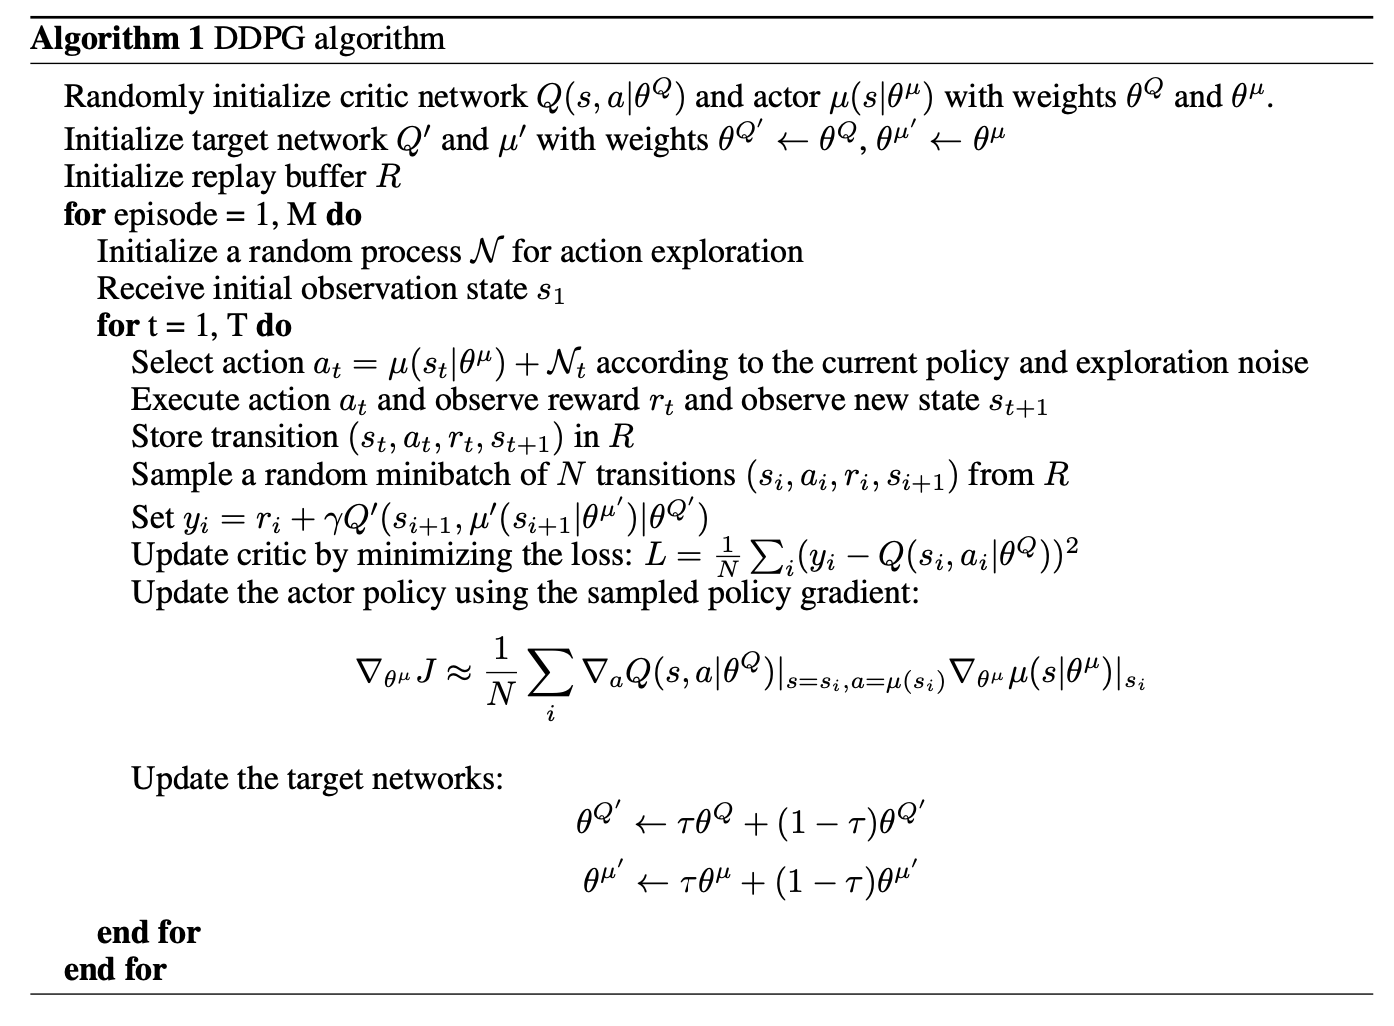

### Resources

- [openai/gym](https://gym.openai.com/docs/)
- [getting-started-with-openai-gym](https://blog.paperspace.com/getting-started-with-openai-gym/)
- [Continuous control with deep reinforcement learning (DDPG)](https://arxiv.org/abs/1509.02971)
- [Deterministic Policy Gradient Algorithms](http://proceedings.mlr.press/v32/silver14.pdf)

You can read about actor policy update step and how to implement it here:
- https://www.quora.com/Why-is-the-loss-for-DDPG-Actor-the-product-of-gradients-of-Q-values-actions
- https://stackoverflow.com/questions/51496159/ddpg-deep-deterministic-policy-gradients-how-is-the-actor-updated


## Requirements

1. Experiments reproducability:

    You should ensure that you can re-run your experiments and obtain the same results. To do so implement `set_seed` function that handles necessary logic. Pick one of the experiments (short one) and re-run it with logging of the losses/mean_rewards to show that results are reproduced.

2. Implement Polyak average for updating network's parameters:

    During labs about DQN you have seen that target's network parameters can be updated every K steps by overwritting old parameters. There are other, more robust, methods to do so. One of the most popular is polyak average (weighted moving average). Your tasks will be to implement it as well.

3. Implement DDPG algorithm:

    Read paper carefully, and don't forget about exploration.

4. Environments:

    Solve the environmets listed below and reach the corresponding benchmark score.

5. Analysis of different hyperparameters.

    Pick one of the environments and repeat the training 5 times with a different subset of hyperparameters such that the results differ. Present comparison of used parameters' configurations, training summary, plots, and your conclusions.

    Tip: RL algorithms are especially parameter sensitive. It's a good occasion to ponder how to organize your work such that you can easily track and compare different runs and configurations. Organize your experiments or use a utility such as [tensorboard](https://pytorch.org/docs/stable/tensorboard.html), [neptune](neptune.ai), [wandb](wandb.ai) or [clearml](https://clear.ml/).


### Evaluation & Grading

Total points: 12
- Seed initalization & experiment reproducibility [0.5]
- Polyak average [0.5]
- Gaussian noise [0.5]
- DDPG [5.5]
- Solving environments (benchmark) [3.0]
- Analysis of different hyperparameters [2.0]

#### Benchmark
For each of the following environments you should train one agent and obtain at least the following mean score in our benchmark:
```
"Pendulum-v1" : -160,
"LunarLanderContinuous-v2": 130,
"MountainCarContinuous-v0": 80
```



Tips:
- Study environment's action space and ensure that your cover the whole range. Perhaps Tanh activation could be useful?
- Adding noise to the action can take you out of the environment's action space. Ensure that the final action is valid before calling `env.step(action)`.
- RL agents tend to forget previously learnt behaviors, especially if algorithm is not very stable. Therefore, it's a good practice to evaluate and save checkpoints (weights of the model) every K-th steps. You can later load the best set of parameters.
- Here are a few statistics that are usefull to track your training progress:
```
logs = {
    "episodes_rews": [],
    "episodes_lens": [],
    "critic_losses": [], 
    "actor_losses": []
}
```
For example, it's useful to log mean episode reward for last 50 episodes.

# Environment setup, helper functions & classes

Remember to restart your runtime after installing the packages.

In [ ]:
!pip3 install 'gym==0.21.0' > /dev/null 2>&1
!pip3 install box2d-py==2.3.8 > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip3 install ez_setup > /dev/null 2>&1
!pip3 install gym[atari] > /dev/null 2>&1
!pip3 install gym[Box_2D] > /dev/null 2>&1
!pip3 install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* > /dev/null 2>&1
!pip install clearml > /dev/null 2>&1

In [ ]:
import copy
import random
import numpy as np
import torch
import torch.nn as nn
from typing import List, Optional, Callable, Tuple
from collections import namedtuple
import imageio
from pathlib import Path
import gym
from pyvirtualdisplay import Display

from clearml import Task

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import torch.nn.functional as F

import time
# torch.use_deterministic_algorithms(True) 

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [ ]:
web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = '8E6XXHL5IUUFBSDPNP3O'  #@param {type:"string"}
secret_key = 'DSQtWLrn4WkgAgeBpbgYIzUzIem0mjaqZHWRbJYqKs2mILxIJr'  #@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

### Benchmark

Don't modify Benchmark's cell. Your solution should pass the proposed thresholds.

In [ ]:
def as_tensor(data: np.ndarray, dtype=torch.float32, batch: bool = False) -> torch.Tensor:
    tensor = torch.tensor(data, dtype=dtype, device=DEVICE)
    if batch and len(tensor.shape) == 1:
        tensor = tensor.unsqueeze(dim=1)
    return tensor

class Benchmark:
    def __init__(self):
        """ Don't modify. Your agent should pass those benchmarks. """
        self.env_to_mean_score = {
            "Pendulum-v1" : -160,
            "LunarLanderContinuous-v2": 130,
            "MountainCarContinuous-v0": 80
        }
        self.n_episodes = 100
        self.seed = 42
    
    def run(self, env_id: str, policy) -> None:
        env = gym.make(env_id)
        stats = self._eval(env, policy, self.n_episodes, self.seed)
        score = np.mean(stats["episodes_rews"])
        result = "Success" if score > self.env_to_mean_score[env_id] else "Failure"
        print(f"{result} on {env_id} with mean score: {score}")
        assert len(stats["episodes_rews"]) == self.n_episodes

    def _eval(self, env, policy, n_episodes: int = 100, seed: Optional[int] = None):
        print("\nStarting Benchmark:")
        print("seed:", seed)
        print("n_episodes:", n_episodes)
        if seed: # Be careful, this will reset your rng!
            set_seeds(env, seed)

        stats = {
            "episodes_rews": [],
            "episodes_lens": [],
        }
        
        for episode in range(n_episodes):
            done = False
            obs = env.reset()
            ep_rew, ep_len = 0, 0

            while not done:
                with torch.no_grad():
                    action = policy(as_tensor(obs)).cpu().numpy() # No exploration noise during evalution!
                obs, reward, done, _ = env.step(action)
                ep_rew += reward
                ep_len += 1
            
            stats["episodes_lens"].append(ep_len)
            stats["episodes_rews"].append(ep_rew)

        print("Rewards:", stats["episodes_rews"])
        print("Lengths:", stats["episodes_lens"])
        print("Mean episode reward:", np.mean(stats["episodes_rews"]))
        print("Mean episode length:", np.mean(stats["episodes_lens"]))

        return stats

### Utilities

A few helper functions to help you get started.

In [ ]:
def eval(env, policy, n_episodes: int = 100, seed: Optional[int] = None):
    """ Helper method to evaluate agent """
    if seed: # Be careful, this will reset your rng!
        set_seeds(env, seed)

    stats = {
        "episodes_rews": [],
        "episodes_lens": [],
    }
    
    for episode in range(n_episodes):
        done = False
        obs = env.reset()
        ep_rew, ep_len = 0, 0

        while not done:
            with torch.no_grad():
                action = policy(as_tensor(obs)).cpu().numpy() # No exploration noise during evalution
            obs, reward, done, _ = env.step(action)
            ep_rew += reward
            ep_len += 1
        
        stats["episodes_lens"].append(ep_len)
        stats["episodes_rews"].append(ep_rew)

    # print("Rewards:", stats["episodes_rews"])
    # print("Lengths:", stats["episodes_lens"])
    # print("Mean episode reward:", np.mean(stats["episodes_rews"]))
    # print("Mean episode length:", np.mean(stats["episodes_lens"]))

    return stats

In [ ]:
def make_gif(env_id, actor = None, n_episodes: int = 1, gif_name: str = "agent.gif", dir: str = "./gifs"):
    """ 
    Create a gif of an agent interacting with an environment.
    Note: It does not always work in Google colab, and crashes from time to time.
    """
    display = Display(visible=0, size=(1400, 900))
    display.start()

    Path(dir).mkdir(parents=True, exist_ok=True)
    filename = Path(dir).joinpath(gif_name)

    images = []
    env = gym.make(env_id)
    for _ in range(n_episodes):
        obs, done = env.reset(), False
        images.append(env.render("rgb_array"))
        while not done:
            if actor:
                with torch.no_grad():
                    action = actor(as_tensor(obs)).cpu().numpy()
            else:
                action = env.action_space.sample() 
            obs, reward, done, _ = env.step(action) 
            images.append(env.render("rgb_array"))

    imageio.mimsave(filename, images, fps=29)

In [ ]:
def try_gpu(i: int = 0) -> None:
    """ Return gpu(i) if exists, otherwise return cpu() """
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In gym environments Box(n,) corresponds to the n-dimensional continuous space. The observation space has upper and lower bounds that describe the range of values it can take.

In [ ]:
def describe_env(env_id: str) -> None:
    print(env_id)
    env = gym.make(env_id)
    spec = gym.spec(env_id)
    print(f"Environment: {env_id}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Observation Space High: {env.observation_space.high}")
    print(f"Observation Space Low: {env.observation_space.low}")
    print(f"Action Space: {env.action_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

continuous_envs = ["Pendulum-v1", "LunarLanderContinuous-v2", "MountainCarContinuous-v0"]

print(80*"#" + "\n")
for i, env in enumerate(continuous_envs):
    describe_env(env)
    print("\n" + 80*"#" + "\n")

################################################################################

Pendulum-v1
Environment: Pendulum-v1
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Observation Space High: [1. 1. 8.]
Observation Space Low: [-1. -1. -8.]
Action Space: Box([-2.], [2.], (1,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None

################################################################################

LunarLanderContinuous-v2
Environment: LunarLanderContinuous-v2
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Observation Space High: [inf inf inf inf inf inf inf inf]
Observation Space Low: [-inf -inf -inf -inf -inf -inf -inf -inf]
Action Space: Box([-1. -1.], [1. 1.], (2,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200

###################################################################

In [ ]:
# is_terminal is a mask indicating whether the state is terminal or not
# it is usefull when using target_net for predicting qvalues.
Transition = namedtuple("Transition",
                        ("state", "action", "next_state", "reward", "is_terminal"))

class ReplayBuffer(object):
    def __init__(self, size: int):
        """ Create new replay buffer.

        Args:
            size: capacity of the buffer
        """
        self._storage = []
        self._capacity = size
        self._next_idx = 0

    def add(self, transition: Transition) -> None:
        if len(self._storage) < self._capacity:
            self._storage.append(None)
        self._storage[self._next_idx] = transition
        self._next_idx = (self._next_idx + 1) % self._capacity

    def sample(self, batch_size: int) -> List[Transition]:
        """ Sample batch of experience from memory.

        Args:
            batch_size: size of the batch

        Returns:
            batch of transitions
        """
        batch = random.sample(self._storage, batch_size)
        return batch

    def __len__(self) -> int:
        return len(self._storage)

In [ ]:
class MLP(nn.Module):
    """ Simple MLP net.

    Each of the layers, despite the last one, is followed by `activation`, and the last one
    is optionally followed by `output_activation`.
    """
    def __init__(self, layers_sizes: List[int], activation: nn.Module = nn.ReLU, output_activation: Optional[nn.Module] = None) -> None:
        super(MLP, self).__init__()

        modules = []
        for in_features, out_features in zip(layers_sizes, layers_sizes[1:-1]):
            modules.extend([
                nn.Linear(in_features, out_features),
                activation()
            ])
        modules.extend([nn.Linear(layers_sizes[-2], layers_sizes[-1])])
        if output_activation:
            modules.extend([output_activation()])
        self.layers = nn.Sequential(*modules)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.layers(obs)

    def save(self, path: str) -> None:
        torch.save(self.state_dict(), path)

    def load(self, path: str) -> None:
        self.load_state_dict(torch.load(path))

In [ ]:
class Actor(MLP):
    def __init__(self, action_scale: float, *args, **kwargs):
        """
        Sometimes environment's have action range bigger than (-1, 1). 
        Thus we want to scale it appropriately to cover the whole range. Here we assume that the
        final layer is Tanh so scaling the output is enough.
        """
        super(Actor, self).__init__(*args, **kwargs)
        self.action_scale = action_scale

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return super().forward(obs) * self.action_scale

In [ ]:
class Critic(MLP):
    def __init__(self, *args, **kwargs):
        super(Critic, self).__init__(*args, **kwargs)

    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([obs, action], 1)
        return super().forward(x)

# Solution

## Code

In [ ]:
def set_seeds(env: gym.Env, seed=42) -> None:
    """
    Set random seeds for reproduceability.
    See: https://pytorch.org/docs/stable/notes/randomness.html
         https://harald.co/2019/07/30/reproducibility-issues-using-openai-gym/
    """
    #########################
    ### TODO - YOUR CODE ####
    #########################
    torch.manual_seed(seed)
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.action_space.seed(seed)

In [ ]:
def polyak_average(net1: nn.Module, net2: nn.Module, tau: float) -> None:
    """ 
    Update parameters of net1 with parameters of net2 as a weighted sum of both.
    """
    #########################
    ### TODO - YOUR CODE ####
    #########################
    for target_param, param in zip(net1.parameters(), net2.parameters()):
        target_param.data.copy_(target_param.data * tau + param.data * (1. - tau))

In [ ]:
def test_polyak_average():
    net1, net2 = MLP([2, 2]), MLP([2, 2])
    with torch.no_grad():
        net1.layers[0].weight.fill_(1)
        net1.layers[0].bias.fill_(1)
        net2.layers[0].weight.fill_(-1) 
        net2.layers[0].bias.fill_(0.5)
    print(list(net1.named_parameters())) 
    print(list(net2.named_parameters())) 
    polyak_average(net1, net2, tau=0.9)
    print(list(net1.named_parameters())) 

    expected_weight = torch.tensor([[0.8, 0.8], [0.8, 0.8]])
    expected_bias = torch.tensor([0.95, 0.95])
    assert torch.allclose(net1.layers[0].weight.data, expected_weight)
    assert torch.allclose(net1.layers[0].bias.data, expected_bias)

test_polyak_average()

[('layers.0.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([1., 1.], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[-1., -1.],
        [-1., -1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[0.8000, 0.8000],
        [0.8000, 0.8000]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.9500, 0.9500], requires_grad=True))]


In [ ]:
def gaussian_action_noise(action_dim: np.ndarray, mean: float, std: float) -> Callable[[], float]:
    """
    Returns function that samples noise of shape action_dim from the normal distribution N(mean, std) 
    """
    #########################
    ### TODO - YOUR CODE ####
    #########################
    return torch.distributions.Normal(mean, std).sample(action_dim).numpy()

In [ ]:
class DDPGAgent:
    def __init__(self, env, actor, critic, actor_target, critic_target, get_action_noise: Callable[[], float], logger, checkpoints_dir: str):
        self.env = env
        self.actor = actor
        self.critic = critic
        self.actor_target = actor_target
        self.critic = critic
        self.critic_target = critic_target
        self.get_action_noise = get_action_noise
        self.logger = logger
        self.checkpoints_dir = checkpoints_dir

        self.actor_optim = None
        self.critic_optim = None
        
        self.gamma = None
        self.polyak = None

        self.noise_mean = None
        self.noise_std = None
        self.noise_std_frac = None
        self.initial_exploration_steps = None
        self.first_exploration_steps = None
        self.exploration_min_frac = None
        self.exploration_frac = None
        
        self.replay_buffer = None
        
        self.action_min = self.env.action_space.low
        self.action_max = self.env.action_space.high

        self.loss_fn = torch.nn.MSELoss()
        
    
    def get_action(self, obs):
        """ 
        Calculate next action with exploration via Gaussian noise
        Remember to:
        1. Not calculate gradients for this forward pass.
        2. Include exploration noise.
        3. Clip action to fit within the environment's action space after adding the noise. 
        """
        #########################
        ### TODO - YOUR CODE ####
        #########################
        obs = obs.unsqueeze(0)
        action = self.actor.forward(obs).detach().squeeze(0).cpu().numpy()
        action += self.get_action_noise(action.shape, self.noise_mean, self.noise_std)
        action = np.clip(action, self.action_min, self.action_max)

        return action


    def get_critic_loss(self, batch):
        """
        Calculate critic's loss for a given batch.
        """
        #########################
        ### TODO - YOUR CODE ####
        #########################
        states, actions, next_states, rewards, _ = batch
        qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states).detach()
        next_q = self.critic_target.forward(next_states, next_actions).detach()
        qprime = rewards + self.gamma * next_q
        critic_loss = self.loss_fn(qvals, qprime)

        return critic_loss


    def get_actor_loss(self, batch):
        """
        Calculate actor's loss for a given batch.
        Remember that we want to maximize qvalue returned by critic, which represents the expected 
        future reward. Therefore, we want to do gradient ascent. However, optimizer always performs 
        gradient descent.
        """
        #########################
        ### TODO - YOUR CODE ####
        #########################
        actor_out = self.actor.forward(batch.state)
        critic_out = self.critic.forward(batch.state, actor_out)
        
        return -critic_out.mean()


    def update_step(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return None, None

        # Sample minibatch
        transitions = self.replay_buffer.sample(batch_size)
        # Convert from list of tuples to tuple of lists
        batch = Transition(*zip(*transitions))
        batch = Transition(as_tensor(batch.state, batch=True), 
                           as_tensor(batch.action, batch=True),
                           as_tensor(batch.next_state, batch=True),
                           as_tensor(batch.reward, batch=True),
                           as_tensor(batch.is_terminal, batch=True))

        # Critic step ~ 4/5 lines
        #########################
        ### TODO - YOUR CODE ####
        #########################
        self.critic_optim.zero_grad()
        critic_loss = self.get_critic_loss(batch)
        critic_loss.backward()
        self.critic_optim.step()

        # Actor step ~ 4/5lines
        #########################
        ### TODO - YOUR CODE ####
        #########################
        self.actor_optim.zero_grad()
        actor_loss = self.get_actor_loss(batch)
        actor_loss.backward()
        self.actor_optim.step()

        # Update target networks ~ 2 lines
        #########################
        ### TODO - YOUR CODE ####
        #########################
        polyak_average(self.actor_target, self.actor, self.polyak)
        polyak_average(self.critic_target, self.critic, self.polyak)

        return actor_loss.item(), critic_loss.item()

In [ ]:
class DDPGAgent(DDPGAgent):
    # Auxiliary functions
    def noise_std_decay(self, series, total_steps_count):
        """
        Decrease noise std exponentially and log it each time.
        """
        self.noise_std = max(self.noise_std * self.noise_std_frac, 0.01)
        self.logger.report_scalar('noise_std', series, iteration=total_steps_count, value=self.noise_std)

    
    def initial_exploration_steps_decay(self, series, total_steps_count):
        """
        Decrease exploration steps exponentially and log it each time.
        """
        self.initial_exploration_steps = max(int(self.first_exploration_steps * self.exploration_min_frac), int(self.initial_exploration_steps * self.exploration_frac))
        self.logger.report_scalar('initial_exploration_steps', series, iteration=total_steps_count, value=self.initial_exploration_steps)

In [ ]:
class DDPGAgent(DDPGAgent):
    def learn(self, actor_optim, critic_optim, episodes: int, total_steps: int, 
              buffer_size: int, batch_size: int, gamma: float, polyak: float, 
              initial_exploration_steps: int, exploration_frac: float, 
              exploration_min_frac: float, noise_mean: float, noise_std: float,
              noise_std_frac: float, checkpoint_save_interval: int, hyper_id: int):
        
        self.actor_optim = actor_optim
        self.critic_optim = critic_optim
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.gamma = gamma
        self.polyak = polyak
        self.noise_mean = noise_mean
        self.noise_std = noise_std
        self.noise_std_frac = noise_std_frac
        self.initial_exploration_steps = initial_exploration_steps
        self.first_exploration_steps = initial_exploration_steps
        self.exploration_min_frac = exploration_min_frac
        self.exploration_frac = exploration_frac
        
        rewards_history = []

        total_steps_count = 0
        series = f'series {hyper_id}'
        for episode in range(episodes):
            state = self.env.reset()
            episode_reward, episode_steps, done = 0, 0, False

            while not done and total_steps_count < total_steps:
                # At the beginning explore randomly before using policy. This helps with exploration.
                if episode_steps < self.initial_exploration_steps:
                    action = self.env.action_space.sample()
                else:
                    action = self.get_action(as_tensor(state))

                next_state, reward, done, _ = self.env.step(action)
                self.replay_buffer.add(Transition(state, action, next_state, reward, done))

                actor_loss, critic_loss = self.update_step(batch_size)

                state = next_state
                episode_reward += reward

                # ClearML
                if actor_loss and critic_loss:
                    self.logger.report_scalar('actor_loss', series, iteration=total_steps_count, value=actor_loss)
                    self.logger.report_scalar('critic_loss', series, iteration=total_steps_count, value=critic_loss)

                # Checkpoint
                if (total_steps_count + 1) % checkpoint_save_interval == 0:
                    self.actor.save(f'{self.checkpoints_dir}/{hyper_id}_actor_params_nsteps{total_steps_count + 1}_nepis{episode}')
                    self.critic.save(f'{self.checkpoints_dir}/{hyper_id}_critic_params_nsteps{total_steps_count + 1}_nepis{episode}')
                    stats = eval(self.env, self.actor)
                    self.logger.report_scalar('val_episodes_lens', series, np.mean(stats['episodes_lens']), total_steps_count+1)
                    self.logger.report_scalar('val_episodes_rews', series, np.mean(stats['episodes_rews']), total_steps_count+1)


                episode_steps += 1
                total_steps_count += 1

            self.noise_std_decay(series, total_steps_count)
            self.initial_exploration_steps_decay(series, total_steps_count)
                    
            rewards_history.append(episode_reward)

            # ClearML
            self.logger.report_scalar('episodes_rews', series, iteration=episode, value=episode_reward)
            self.logger.report_scalar('episodes_rews_mean_100', series, iteration=episode, value=np.mean(rewards_history[-100:]))
            self.logger.report_scalar('episodes_rews_mean_50', series, iteration=episode, value=np.mean(rewards_history[-50:]))
            self.logger.report_scalar('episodes_rews_mean_25', series, iteration=episode, value=np.mean(rewards_history[-25:]))
            
            self.logger.report_scalar('episodes_lens', series, iteration=episode, value=episode_steps)

            if total_steps_count == total_steps:
                break

In [ ]:
DEVICE = try_gpu()
DEVICE

device(type='cpu')

In [ ]:
dirs = dict()
for env_id in continuous_envs:
    dirs[env_id] = {'log_dir': f'runs/{env_id}',
                    'tensorboard': f'runs/{env_id}/tensorboard',
                    'checkpts': f'runs/{env_id}/checkpoints'}

    Path(dirs[env_id]['checkpts']).mkdir(parents=True, exist_ok=True)

In [ ]:
def get_hyperparams():
    pendulum = {
        'episodes': int(2e4),
        'total_steps': 50000,
        'buffer_size': 250000,
        'batch_size': 128,
        'gamma': 0.99,
        'polyak': 1. - 1e-3,
        'initial_exploration_steps': 200,
        'exploration_frac': 0.95,
        'exploration_min_frac': 0.1,
        'noise_mean': 0.,
        'noise_std': 1.,
        'noise_std_frac': 0.99,
        'checkpoint_save_interval': 5000
    }

    lunar = dict(pendulum)
    lunar.update({
        'batch_size': 64,
        'exploration_frac': 0.9,
        'exploration_min_frac': 0.,
        'initial_exploration_steps': 1000,
        'noise_std_frac': 0.999,
        'total_steps': 150000
    })

    mountain = dict(pendulum)
    mountain.update({
        'exploration_frac': 0.9,
        'exploration_min_frac': 0.,
        'initial_exploration_steps': 999,
        'noise_std_frac': 0.999,
        'total_steps': 110000
    })

    lr1 = {
        'actor': 1e-4,
        'critic': 1e-3
    }
    
    lr2 = {
        'actor': 5e-5,
        'critic': 5e-4
    }

    return [(pendulum, lr1), (lunar, lr2), (mountain, lr1)]

In [ ]:
def train(hyper_id, hyperparams, lrs, describe=True):
    env_id = continuous_envs[hyper_id]
    if describe:
        describe_env(env_id)
    env = gym.make(env_id)

    task = Task.init(project_name='GSN Homework - DDPG', task_name=f'experiment_{env_id}', reuse_last_task_id=False)
    logger = task.get_logger()

    checkpoints_dir = dirs[env_id]['checkpts']
    
    set_seeds(env, seed=12)
    
    # log hyperparams
    print(f'hyperparams: {hyperparams}')
    task.connect(hyperparams)

    actions_shape = env.action_space.shape[0],
    obs_shape = env.observation_space.shape[0],
    hidden_size = 256
    actor_layers_sizes = [obs_shape[0],
                            hidden_size,
                            hidden_size,
                            actions_shape[0]]
    critic_layers_sizes = [obs_shape[0] + actions_shape[0],
                            hidden_size,
                            hidden_size,
                            actions_shape[0]]

    action_scale = env.action_space.high[0]

    actor = Actor(action_scale=action_scale, layers_sizes=actor_layers_sizes, output_activation=nn.Tanh).to(DEVICE)
    critic = Critic(layers_sizes=critic_layers_sizes).to(DEVICE)
    actor_target = Actor(action_scale=action_scale, layers_sizes=actor_layers_sizes, output_activation=nn.Tanh).to(DEVICE)
    critic_target = Critic(layers_sizes=critic_layers_sizes).to(DEVICE)

    actor_optim = torch.optim.Adam(actor.parameters(), lr=lrs['actor'])
    critic_optim = torch.optim.Adam(critic.parameters(), lr=lrs['critic'])

    polyak_average(critic_target, critic, 0)
    polyak_average(actor_target, actor, 0)

    agent = DDPGAgent(env, actor, critic, actor_target, critic_target, gaussian_action_noise, logger, checkpoints_dir)
    agent.learn(actor_optim=actor_optim, critic_optim=critic_optim, hyper_id=hyper_id, **hyperparams)

    return actor, task

In [ ]:
def create_plots(scalars, h_id):
    fig = make_subplots(rows=3, cols=2, subplot_titles=plots_titles)

    for id, title in enumerate(plots_titles):
        x = scalars[title][f'series {h_id}']['x']
        y = scalars[title][f'series {h_id}']['y']
        fig.add_trace(go.Scatter(x=x, y=y), row=int(id / 2) + 1, col=id % 2 + 1)
    fig.show()

def create_plots2(scalars, h_id, names, colors, main_title):
    fig = make_subplots(rows=4, cols=2, subplot_titles=plots_titles)
    
    for id, title in enumerate(plots_titles):
        for i, name, color in zip(range(len(scalars)), names, colors):
            x = scalars[i][title][f'series {h_id}']['x']
            y = scalars[i][title][f'series {h_id}']['y']
            fig.add_trace(go.Scatter(x=x, y=y, name=name, marker_color=color, showlegend=False), row=int(id / 2) + 1, col=id % 2 + 1)
    fig.update_layout(title_text=main_title)
    fig.show()

In [ ]:
hyperparams_list = get_hyperparams()
benchmark = Benchmark()
plots_titles = ['actor_loss', 'critic_loss', 'episodes_rews', 'episodes_rews_mean_100', 'val_episodes_rews', 'val_episodes_lens']

## Benchmarks

### Pendulum

In [ ]:
id = 0
actor, task = train(id, *(hyperparams_list[id]))

Pendulum-v1
Environment: Pendulum-v1
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Observation Space High: [1. 1. 8.]
Observation Space Low: [-1. -1. -8.]
Action Space: Box([-2.], [2.], (1,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None
ClearML Task: created new task id=62b265dcf3164d51957bbfd442987a25
2022-02-01 14:43:36,376 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.community.clear.ml/projects/92f8e6e11214468c95c3f6eb8839f7a2/experiments/62b265dcf3164d51957bbfd442987a25/output/log
hyperparams: {'episodes': 20000, 'total_steps': 50000, 'buffer_size': 250000, 'batch_size': 128, 'gamma': 0.99, 'polyak': 0.999, 'initial_exploration_steps': 200, 'exploration_frac': 0.95, 'exploration_min_frac': 0.1, 'noise_mean': 0.0, 'noise_std': 1.0, 'noise_std_frac': 0.99, 'checkpoint_save_interval': 5000}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



2022-02-01 14:47:16,818 - clearml.frameworks - INFO - Found existing registered model id=1d25aa34add44de39cfd1fda9adfee96 [/content/runs/Pendulum-v1/checkpoints/0_actor_params_nsteps5000_nepis24] reusing it.
2022-02-01 14:47:26,022 - clearml.frameworks - INFO - Found existing registered model id=500031c62b15467ba776b7ce2df23719 [/content/runs/Pendulum-v1/checkpoints/0_critic_params_nsteps5000_nepis24] reusing it.
2022-02-01 14:50:19,430 - clearml.frameworks - INFO - Found existing registered model id=8f88a76aab6d4549826e88e5ee34db38 [/content/runs/Pendulum-v1/checkpoints/0_actor_params_nsteps10000_nepis49] reusing it.
2022-02-01 14:50:28,644 - clearml.frameworks - INFO - Found existing registered model id=ba37bb9f0082446bb1daad9614af5e3b [/content/runs/Pendulum-v1/checkpoints/0_critic_params_nsteps10000_nepis49] reusing it.
2022-02-01 14:53:22,338 - clearml.frameworks - INFO - Found existing registered model id=4cb7e3aaed554f10b50affca2dc1eac9 [/content/runs/Pendulum-v1/checkpoints/0_a

In [ ]:
actor.load(dirs[continuous_envs[id]]['checkpts']+'/0_actor_params_nsteps45000_nepis224')
benchmark.run(continuous_envs[id], actor)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [-132.47028552972307, -233.13166836906444, -132.97598955813893, -234.27851656412778, -124.27322162208341, -126.26277603498485, -125.74242680250667, -132.91281946703225, -130.94526944678609, -292.8465729882288, -239.42188240808372, -224.15107228814918, -327.8252189881711, -229.33032328244525, -125.09584644867985, -124.86178995746164, -228.79088206355215, -233.39884840670248, -247.36303468511352, -229.95727673940294, -127.13330476057959, -225.08329928853027, -134.9113869806331, -124.6469776956007, -133.4072468036343, -236.50114601839942, -248.76554021294828, -228.58250190246767, -243.40949210674367, -233.05363195884988, -120.73858268634339, -125.06363635530973, -274.34371655354084, -7.542212679525942, -132.61569969896382, -232.84448656414008, -132.68313648627836, -122.20029189196414, -6.938306635598018, -122.79567428543379, -120.21472244044874, -128.1038449323712, -122.14131833347052, -235.71276558995365, -118.52754821293294, -125.95

In [ ]:
for i in range(5):
    make_gif(continuous_envs[id], gif_name=f'agent{id}_{i}.gif', actor=actor)

In [ ]:
scalars = task.get_reported_scalars()
create_plots(scalars, id)

In [ ]:
task.close()

### Lunar Lander

In [ ]:
id = 1
actor, task = train(id, *(hyperparams_list[id]))

LunarLanderContinuous-v2
Environment: LunarLanderContinuous-v2
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Observation Space High: [inf inf inf inf inf inf inf inf]
Observation Space Low: [-inf -inf -inf -inf -inf -inf -inf -inf]
Action Space: Box([-1. -1.], [1. 1.], (2,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200
ClearML Task: created new task id=a65308081e634c38bf7c5d3343c076e5
2022-02-01 18:46:15,823 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.community.clear.ml/projects/92f8e6e11214468c95c3f6eb8839f7a2/experiments/a65308081e634c38bf7c5d3343c076e5/output/log
hyperparams: {'episodes': 20000, 'total_steps': 150000, 'buffer_size': 250000, 'batch_size': 64, 'gamma': 0.99, 'polyak': 0.999, 'initial_exploration_steps': 1000, 'exploration_frac': 0.9, 'exploration_min_frac': 0.0, 'noise_mean': 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



2022-02-01 18:50:01,898 - clearml.frameworks - INFO - Found existing registered model id=08dd4640a3044d75b612c146ae6fee28 [/content/runs/LunarLanderContinuous-v2/checkpoints/1_actor_params_nsteps5000_nepis51] reusing it.
2022-02-01 18:50:06,546 - clearml.frameworks - INFO - Found existing registered model id=4d86cc8bead14b63978ee8819a2a3d27 [/content/runs/LunarLanderContinuous-v2/checkpoints/1_critic_params_nsteps5000_nepis51] reusing it.
2022-02-01 18:52:50,360 - clearml.frameworks - INFO - Found existing registered model id=de29561541fa40638e0e4adde25c250f [/content/runs/LunarLanderContinuous-v2/checkpoints/1_actor_params_nsteps10000_nepis106] reusing it.
2022-02-01 18:52:55,004 - clearml.frameworks - INFO - Found existing registered model id=daa80fc26263412cb0d15356c2603c14 [/content/runs/LunarLanderContinuous-v2/checkpoints/1_critic_params_nsteps10000_nepis106] reusing it.
2022-02-01 18:55:49,264 - clearml.frameworks - INFO - Found existing registered model id=b9136e14821749cea475e

In [ ]:
actor.load(dirs[continuous_envs[id]]['checkpts']+f'/{id}_actor_params_nsteps145000_nepis494')
benchmark.run(continuous_envs[id], actor)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [249.10682275844093, 224.23702481434213, 263.91853216225195, 202.82607072532284, 181.57226615059733, 181.52977332513387, -21.917191208796424, 226.69832636304875, -17.2296580261022, 263.64162227382485, 257.5372827995701, 238.30945459725783, 259.44564550586387, 231.9328783714227, 236.86431455132748, 13.110296186840927, -77.86048352310014, 226.45792938713038, 250.6659320451664, 235.68889457997673, 211.27016050328592, -65.72899996685571, 250.47639655198998, 233.39100128120393, 154.38978740996603, 23.519284060085056, 244.88978694413532, 220.07162479196828, 233.05250687801308, 262.05014007283347, 213.3027520208841, 273.9564490766461, 204.7589883392257, 205.58636558859143, -90.83179159598374, 236.60384863749454, 16.302992617232675, 256.6813714208021, 191.3573065170685, 228.90829979012443, 18.644876641618865, -84.30738389890395, -3.1818146163492855, 285.51919051896436, 175.27426944672902, -41.59327255465704, 245.2492164731872, 172.86834496

In [ ]:
for i in range(5):
    make_gif(continuous_envs[id], gif_name=f'agent{id}_{i}.gif', actor=actor)

2022-02-01 23:58:16,471 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_model/v2.13 (Invalid task status: expected=created, status=completed)> (task=98b19c102645422cbf75676c1b116d8d, name=1_actor_params_nsteps145000_nepis494, model=2e6929ecde644838902a894f397a9ebc, type=input)


In [ ]:
scalars = task.get_reported_scalars()
create_plots(scalars, id)

In [ ]:
task.close()

### Mountain Car

In [ ]:
id = 2
actor, task = train(id, *(hyperparams_list[id]))

MountainCarContinuous-v0
Environment: MountainCarContinuous-v0
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Observation Space High: [0.6  0.07]
Observation Space Low: [-1.2  -0.07]
Action Space: Box([-1.], [1.], (1,), float32)
Max Episode Steps: 999
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 90.0


KeyboardInterrupt: ignored

In [ ]:
actor.load(dirs[continuous_envs[id]]['checkpts']+f'/{id}_actor_params_nsteps110000_nepis220')
benchmark.run(continuous_envs[id], actor)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [93.60971633183848, 93.60222720836342, 93.78215293461923, 93.60220444527091, 93.6063993775455, 93.72783028322031, 93.62506384646755, 93.6085559045982, 93.60286354229653, 93.73187755323403, 93.72441048472682, 93.79932530280372, 93.62476462696492, 93.77103028246147, 93.6071407872694, 93.60651693323757, 93.61084249950204, 88.6539024193171, 88.4255048450069, 93.79164379014233, 93.5919289152051, 93.7790027081763, 93.50622066456526, 88.7097116846219, 93.8003292448444, 93.55252678619222, 93.54039687817834, 93.60697678938749, 93.61122015750763, 93.7760937234075, 93.59858042316338, 93.765650067203, 93.77100203050443, 93.73357124720934, 88.6098946101965, 93.60231925436999, 93.57829171476479, 93.56071151095483, 93.78135962192142, 93.7170428219492, 93.76021749606153, 93.3587397435359, 93.56090765620009, 93.6048239446227, 93.60242380151332, 93.55555750537917, 93.7417867395576, 88.26174306499053, 93.6024931195164, 88.24864372280008, 93.777411257

In [ ]:
for i in range(5):
    make_gif(continuous_envs[id], gif_name=f'agent{id}_{i}.gif', actor=actor)

2022-02-02 00:00:55,913 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_model/v2.13 (Invalid task status: expected=created, status=completed)> (task=98b19c102645422cbf75676c1b116d8d, name=2_actor_params_nsteps110000_nepis220, model=9d4029d2a1824aa8939126aaba2424c0, type=input)


In [ ]:
scalars = task.get_reported_scalars()
create_plots(scalars, id)

In [ ]:
task.close()

## Set seed check

In [ ]:
id = 0
params, lrs = hyperparams_list[id]
params2 = dict(params)
params2['total_steps'] = 5000

# First experiment
actor, task = train(id, params2, lrs)
time.sleep(0.5)
scalars1 = task.get_reported_scalars()
time.sleep(0.5)
task.close()
time.sleep(0.5)

# Second experiment
actor, task = train(id, params2, lrs)
time.sleep(0.5)
scalars2 = task.get_reported_scalars()
time.sleep(0.5)
task.close()
time.sleep(0.5)

Pendulum-v1
Environment: Pendulum-v1
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Observation Space High: [1. 1. 8.]
Observation Space Low: [-1. -1. -8.]
Action Space: Box([-2.], [2.], (1,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None
ClearML Task: created new task id=49468b156f9c4483b5cfe0eb0141b4b5
ClearML results page: https://app.community.clear.ml/projects/92f8e6e11214468c95c3f6eb8839f7a2/experiments/49468b156f9c4483b5cfe0eb0141b4b5/output/log
2022-02-01 22:44:31,286 - clearml.Task - INFO - No repository found, storing script code instead
hyperparams: {'episodes': 20000, 'total_steps': 5000, 'buffer_size': 250000, 'batch_size': 128, 'gamma': 0.99, 'polyak': 0.999, 'initial_exploration_steps': 200, 'exploration_frac': 0.95, 'exploration_min_frac': 0.1, 'noise_mean': 0.0, 'noise_std': 1.0, 'noise_std_frac': 0.99, 'checkpoint_save_interval': 5000}
2022-02-01 22:47:00,162 - clearml.frameworks - INFO - Fou

In [ ]:
min_shape = min(np.array(scalars1['critic_loss'][f'series 0']['y']).shape[0], np.array(scalars2['critic_loss'][f'series 0']['y']).shape[0])
assert(np.allclose(np.array(scalars1['critic_loss'][f'series 0']['y'])[:min_shape], np.array(scalars2['critic_loss'][f'series 0']['y'])[:min_shape]))
min_shape = min(np.array(scalars1['actor_loss'][f'series 0']['y']).shape[0], np.array(scalars2['actor_loss'][f'series 0']['y']).shape[0])
assert(np.allclose(np.array(scalars1['actor_loss'][f'series 0']['y'])[:min_shape], np.array(scalars2['actor_loss'][f'series 0']['y'])[:min_shape]))
min_shape = min(np.array(scalars1['episodes_rews'][f'series 0']['y']).shape[0], np.array(scalars2['episodes_rews'][f'series 0']['y']).shape[0])
assert(np.allclose(np.array(scalars1['episodes_rews'][f'series 0']['y'])[:min_shape], np.array(scalars2['episodes_rews'][f'series 0']['y'])[:min_shape]))
min_shape = min(np.array(scalars1['episodes_lens'][f'series 0']['y']).shape[0], np.array(scalars2['episodes_lens'][f'series 0']['y']).shape[0])
assert(np.allclose(np.array(scalars1['episodes_lens'][f'series 0']['y'])[:min_shape], np.array(scalars2['episodes_lens'][f'series 0']['y'])[:min_shape]))
print('All good')

All good


## Analysis of different hyperparams

In [ ]:
id = 1
params, lrs = hyperparams_list[id]
params2 = dict(params)
params2['total_steps'] = 100000

params2['noise_std'] = 0.
params2['noise_std_frac'] = 1.
actor, task = train(id, params2, lrs, False)
time.sleep(0.5)
scalars1 = task.get_reported_scalars()
time.sleep(0.5)
task.close()
time.sleep(0.5)

params2['noise_std'] = 2.
params2['noise_std_frac'] = 1.
actor, task = train(id, params2, lrs, False)
time.sleep(0.5)
scalars2 = task.get_reported_scalars()
time.sleep(0.5)
task.close()
time.sleep(0.5)

# params2['noise_std'] = 0.
# params2['noise_std_frac'] = 1.
# actor, task = train(id, params2, lrs, False)
# time.sleep(0.5)
# scalars3 = task.get_reported_scalars()
# time.sleep(0.5)
# task.close()
# time.sleep(0.5)

ClearML Task: created new task id=69a98c06621c40a1b5811c5d2cf22282
2022-02-03 13:53:28,811 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.community.clear.ml/projects/92f8e6e11214468c95c3f6eb8839f7a2/experiments/69a98c06621c40a1b5811c5d2cf22282/output/log
hyperparams: {'episodes': 20000, 'total_steps': 100000, 'buffer_size': 250000, 'batch_size': 64, 'gamma': 0.99, 'polyak': 0.999, 'initial_exploration_steps': 1000, 'exploration_frac': 0.9, 'exploration_min_frac': 0.0, 'noise_mean': 0.0, 'noise_std': 0.0, 'noise_std_frac': 1.0, 'checkpoint_save_interval': 5000}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



ClearML Task: created new task id=f555b8b335e64575a23eddee78dc773f
ClearML results page: https://app.community.clear.ml/projects/92f8e6e11214468c95c3f6eb8839f7a2/experiments/f555b8b335e64575a23eddee78dc773f/output/log
2022-02-03 14:52:43,097 - clearml.Task - INFO - No repository found, storing script code instead
hyperparams: {'episodes': 20000, 'total_steps': 100000, 'buffer_size': 250000, 'batch_size': 64, 'gamma': 0.99, 'polyak': 0.999, 'initial_exploration_steps': 1000, 'exploration_frac': 0.9, 'exploration_min_frac': 0.0, 'noise_mean': 0.0, 'noise_std': 2.0, 'noise_std_frac': 1.0, 'checkpoint_save_interval': 5000}


In [ ]:
id = 1
params, lrs = hyperparams_list[id]
params2 = dict(params)
params2['total_steps'] = 100000

params2['initial_exploration_steps'] = 400
params2['exploration_frac'] = 1.
actor, task = train(id, params2, lrs, False)
time.sleep(0.5)
scalars3 = task.get_reported_scalars()
time.sleep(0.5)
task.close()
time.sleep(0.5)

params2['initial_exploration_steps'] = 20
params2['exploration_frac'] = 1.
actor, task = train(id, params2, lrs, False)
time.sleep(0.5)
scalars4 = task.get_reported_scalars()
time.sleep(0.5)
task.close()
time.sleep(0.5)

ClearML Task: created new task id=9210eace509042589d1657f2b251a067
2022-02-03 18:00:54,231 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.community.clear.ml/projects/92f8e6e11214468c95c3f6eb8839f7a2/experiments/9210eace509042589d1657f2b251a067/output/log
hyperparams: {'episodes': 20000, 'total_steps': 100000, 'buffer_size': 250000, 'batch_size': 64, 'gamma': 0.99, 'polyak': 0.999, 'initial_exploration_steps': 20, 'exploration_frac': 1.0, 'exploration_min_frac': 0.0, 'noise_mean': 0.0, 'noise_std': 1.0, 'noise_std_frac': 0.999, 'checkpoint_save_interval': 5000}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [ ]:
id = 1
params, lrs = hyperparams_list[id]
params2 = dict(params)
params2['total_steps'] = 100000

params2['gamma'] = 0.999
actor, task = train(id, params2, lrs, False)
time.sleep(0.5)
scalars5 = task.get_reported_scalars()
time.sleep(0.5)
task.close()
time.sleep(0.5)

params2['gamma'] = 0.9
actor, task = train(id, params2, lrs, False)
time.sleep(0.5)
scalars6 = task.get_reported_scalars()
time.sleep(0.5)
task.close()
time.sleep(0.5)

ClearML Task: created new task id=d9852f2459584973aa603f25a5981781
ClearML results page: https://app.community.clear.ml/projects/92f8e6e11214468c95c3f6eb8839f7a2/experiments/d9852f2459584973aa603f25a5981781/output/log
2022-02-03 20:05:17,021 - clearml.Task - INFO - No repository found, storing script code instead
hyperparams: {'episodes': 20000, 'total_steps': 100000, 'buffer_size': 250000, 'batch_size': 64, 'gamma': 0.999, 'polyak': 0.999, 'initial_exploration_steps': 1000, 'exploration_frac': 0.9, 'exploration_min_frac': 0.0, 'noise_mean': 0.0, 'noise_std': 1.0, 'noise_std_frac': 0.999, 'checkpoint_save_interval': 5000}
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2022-02-03 20:26:17,023 - clearml.frameworks - INFO - Found existing registered model id=d2a1f2a04ba04080aff08e95b2c08a79 [/content/runs/LunarLanderContinuous-v2/checkpoints/1_actor_params_nsteps35000_nepis270] reusing it.
2022-02-03 20:26:17,905 - clearml.frameworks - INFO - Foun

In [ ]:
task = Task.get_task('69a98c06621c40a1b5811c5d2cf22282')
scalars1 = task.get_reported_scalars()
task = Task.get_task('f555b8b335e64575a23eddee78dc773f')
scalars2 = task.get_reported_scalars()
task = Task.get_task('76e304a473d04c13b1cb5e90a3622904')
scalars3 = task.get_reported_scalars()

In [ ]:
plots_titles = ['actor_loss', 'critic_loss', 'episodes_rews_mean_100', 'episodes_rews_mean_25', 'episodes_rews', 'episodes_lens', 'val_episodes_rews', 'val_episodes_lens']

In [ ]:
create_plots2([scalars1, scalars2], id, ['noise_std=0', 'noise_std=2'], ['red', 'green'], main_title='noise std')

In [ ]:
create_plots2([scalars3, scalars4], id, ['initial_exploration_steps=400', 'initial_exploration_steps=20'], ['red', 'green'], main_title='initial exploration steps')

In [ ]:
create_plots2([scalars5, scalars6], id, ['gamma=0.999', 'gamma=0.9'], ['red', 'green'], main_title='gamma')

## Analysis of different hyperparameters.

I have chosen three pairs of values for different hyperparameters. That leads to training 6 different models. Each analysis is made basing on **Lunar Lander** env.

### Noise std
As a first hyperparameter to examine its impact on training process I have chosen **standard deviation** value applied to actions to create some gaussian noise. Compared values are equal to 2 and 0 so those are extreme values for this action space. 

+ Noise std = 2 forces model to use more extreme powers of lander engines by decreasing probability that chosen force will be less than 50% (which is equivalent to switching engine off). Actor loss and critic loss are much smoother probably thanks to distribution change of possible actions.

+ Episode lenghts are much greater, really often equal to max possible value (1000) which is expected and necesseary for smooth landing so we can consider it as good.

+ Model with noise std = 2 trains itself much faster by achieving high rewards after each episode.

+ Problem might be that it has low variance of achieved rewards, so it can be hard to cross the barier set by high benchmarks

### Initial exploration steps

Second chosen parameter is initial exploration steps number. It determines number of random steps at the beginning of each episode. Chosen values were pretty extreme, first equal to 400, second 20.

+ We can see that value equal to 400 is too high. It makes too many random moves and with a few exceptions it can't even pass this number of steps.

+ By analysis of mean duration of each episode we can say that value should be much less than 200 for sure.

+ From the other side value equal to 20 leads to many long episodes, which is not that expected for the whole training process, because the goal could be achieved much faster than with 1000 steps and model should explore more.
Taking all this into consideration in final model I have used decreasing value of initial steps to optimize pros and cons of this approach.

### Gamma

Third and last examined hyperparameter was gamma. Models were evaluated for values 0.9 and 0.999.

+ For gamma equal to 0.999 actor loss is much smoother and achieves values closer to 0, similarly for critic loss starting at some point.

+ Mean reward from 100 episodes is, starting at some point, much grater for gamma=0.999 which is a positive impact

+ For the first ~250 episodes, episodes length is pretty much equal for both parameters values but at that point gamma=0.9 starts using more steps per episode which is not that good because gamma=0.999 is able to achieve much better results on validation set using much less steps.

+ On the other hand, gamma=0.9 much quicker recognizes that longer flights are better because it makes smooth landing much more possible. Taking all this into consideration I have chosen 0.99 as the final gamma value in training process which uses benefits from both sides.
